<a href="https://colab.research.google.com/github/mehdi-jamaseb/BinancePrdt/blob/master/binance_pridicator_exprimintal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God
###imports

In [1]:
import pandas as pd
import time
import math
import os.path
import time
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, LSTM, Convolution1D
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from sklearn.metrics import mean_absolute_error
from google.colab import drive



Using TensorFlow backend.


###initilize parameter

In [2]:
drive.mount('/content/drive',force_remount=True)
np.random.seed(42)
samples       = 1000
kandel        = '5m'
symbol        = 'BTCUSDT'
filename      = '/content/drive/My Drive/data/bnb/%s-%s-data.csv' % (symbol,kandel)
df            = pd.read_csv(filename)
dataCols      = ['open','close','low','high','volume']
zeroBaseCols  = [True,True,True,True,False]
df.set_index('timestamp', inplace=True)
df            = df.apply(lambda col:pd.to_numeric(col, errors='coerce'))
df.index      = df.index.astype(str)

if samples>0:
  df          = df.loc[df['volume']>0.001,dataCols].tail(samples)
else:
  df          = df.loc[df['volume']>0.001,dataCols]
outputs       = pd.DataFrame(data=['close','high'])
window_len    = 99
test_size     = 0.2
zero_base     = True
modelNames    = ['LSTM1','LSTM2']
print(df.tail(5))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
                        open    close      low     high      volume
timestamp                                                          
2020-02-10 14:05:00  9815.67  9841.08  9815.24  9843.89  177.836224
2020-02-10 14:10:00  9841.91  9843.72  9838.31  9852.27  193.570387
2020-02-10 14:15:00  9846.04  9839.00  9837.01  9850.60  174.423399
2020-02-10 14:20:00  9838.94  9841.59  9835.30  9845.02   28.681992
2020-02-10 14:20:00  9838.94  9831.48  9827.89  9845.02 

###Functions

In [0]:
def trainTestSplit(df, test_size=0.2):    
  split_row = len(df) - int(test_size * len(df))
  train_data = df.iloc[:split_row]        
  test_data = df.iloc[split_row:]    
  return train_data, test_data
def linePlot(line1, line2, label1=None, label2=None, title='', lw=2):    
  fig, ax = plt.subplots(1, figsize=(13, 7))    
  ax.plot(line1, label=label1, linewidth=lw)    
  ax.plot(line2, label=label2, linewidth=lw)    
  ax.set_ylabel('price [USDT]', fontsize=14)
  ax.set_title(title, fontsize=16)
  ax.legend(loc='best', fontsize=16)
def normaliseZeroBase(df):
  return df / df.iloc[0] - 1
def normaliseMinMax(df):
    return (df - df['low'].min()) / (df['high'].max() - df['low'].min())
def extractWindowData(df, window_len=5, zero_base=True):
  window_data = []    
  #start_time = time.time()
  for idx in range(len(df) - window_len):        
    tmp           = df[idx: (idx + window_len)].copy()
    if zero_base:
      tmp         = normaliseZeroBase(tmp)
    window_data.append(tmp.values)
    #if (idx % 10000)==0:
    #  print("--- extract iteration(%d) %s seconds ---" % (idx,(time.time() - start_time)))    
    #  start_time = time.time()
  return np.array(window_data)
def extractX(df,outputs, window_len=5, zero_base=True,isTest=False):
    k=0
    x = np.zeros((len(df)-window_len,window_len,len(df.columns)))
    for i in range (window_len):    
        x[:,i,:] = df.iloc[i:-(window_len-i),:].values    
        if zero_base:
            if i!=0:
                x[:,i,:] = x[:,i,:]/x[:,0,:]-1        
        k = k+ len(df.columns)
    if zero_base:
      x[:,0,:] =0;  
    if isTest:
      return x
    else:
      return x[:-len(outputs)]
def extractY(df,outputs,window_len,zero_base,isTest=False):
    nCol  = outputs.count().sum()
    y     = np.zeros((len(df)-window_len,nCol))
    k     = 0;
    for i in range(len(outputs)):
        for j in range(len(outputs.columns)):
          if outputs.iloc[i,j]!=None:
            if i==0:
                y[:,k]  = df[outputs.iloc[i,j]][(window_len+i):].values
            else:
                y[:-i,k]= df[outputs.iloc[i,j]][(window_len+i):].values        
            if zero_base:
              y[:,k] = y[:,k] / df[outputs.iloc[i,j]][:-window_len].values -1
            k = k+1
    if isTest:
      return y
    else:
      return y[:-len(outputs),:]
#def pridiction(X,model):

def createDatasets(train_data,test_data, window_len=10, zero_base=True):  
    X_train   = extractX(train_data,outputs, window_len, zero_base)    
    X_test    = extractX(test_data, outputs,window_len, zero_base)    
    y_train   = extractY(train_data,outputs, window_len, zero_base)
    y_test    = extractY(test_data,outputs, window_len, zero_base)
    return X_train, X_test, y_train, y_test
def prepairData(df,target_col, window_len=10, zero_base=True, test_size=0.2,recreate=False):
  datasetFiles = ['X_train','X_test','y_train','y_test']
  recreateFile = recreate;
  outputsSize  = sum(outputs.count())
  for fname in datasetFiles:    
    f = '/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % (fname,symbol, window_len,kandel,outputsSize)
    if not os.path.isfile(f): 
      recreateFile=True
      break
  if recreateFile:
    print('Create Datasets ')  
    train, test  = trainTestSplit(df, test_size=test_size)    
    X_train, X_test, y_train, y_test = createDatasets(train,test, target_col, window_len=window_len, zero_base=zero_base)  
    train.to_pickle('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('train',symbol, window_len,kandel,outputsSize))  
    test.to_pickle ('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('test' ,symbol, window_len,kandel,outputsSize))   
    np.save('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('X_train',symbol, window_len,kandel,outputsSize),X_train)  
    np.save('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('X_test' ,symbol, window_len,kandel,outputsSize),X_test)  
    np.save('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('y_train',symbol, window_len,kandel,outputsSize),y_train)  
    np.save('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('y_test' ,symbol, window_len,kandel,outputsSize),y_test)
  else:
    print('Load Datasets ')
    train   = pd.read_pickle('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('train',symbol, window_len,kandel,outputsSize))
    test    = pd.read_pickle('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('test' ,symbol, window_len,kandel,outputsSize))
    X_train = np.load('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('X_train',symbol, window_len,kandel,outputsSize))
    X_test  = np.load('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('X_test' ,symbol, window_len,kandel,outputsSize))
    y_train = np.load('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('y_train',symbol, window_len,kandel,outputsSize))
    y_test  = np.load('/content/drive/My Drive/data/bnb/%s-%s-w%d-%s-%d.npy' % ('y_test' ,symbol, window_len,kandel,outputsSize))
  return train, test, X_train, X_test, y_train, y_test

###models build functions

In [0]:
metrics = ['mse']
def build_lstm_1_model(input_data, outputs, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=outputs.count().sum()))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
def build_lstm_2_model(input_data, outputs, neurons=20, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=outputs.count().sum(), activation=activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
def getBuildedModel(X_train,modelName,outputs):
    if modelName == modelNames[0]:        
        epochs        = 20
        batchSize     = 256
        model         = build_lstm_1_model(X_train, outputs, neurons=200, dropout=0.2, loss='mse', optimizer='adam')
    elif modelName == modelNames[1]:        
        epochs        = 100
        batchSize     = 256
        model         = build_lstm_2_model(X_train, outputs, neurons=20, dropout=0.2, loss='mse', optimizer='adam')    
    return epochs, batchSize, model 

###data visualation

In [0]:
train, test  = trainTestSplit(df, test_size=test_size)    
X_train, X_test, y_train, y_test = createDatasets(train,test, window_len=window_len, zero_base=zero_base)  

###Data visualize

###Train models

build LSTM1 the model




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 699 samples, validate on 99 samples
Epoch 1/20





699/699 [==============================] - 11s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 2/20
699/699 [==============================] - 0s 703us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/20
699/699 [==============================] - 0s 706us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 4/20
699/699 [==============================] - 1s 783us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/20
699/699 [==============================] - 1

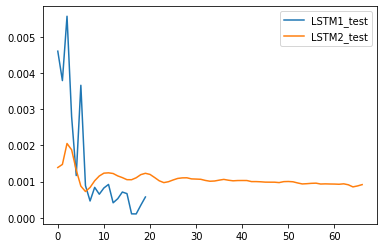

In [9]:
k           = 0
models      = []
histories   = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#1a55FF']

for iter in range(len(modelNames)):
  backUpFile    = '/content/drive/My Drive/data/bnb/%s-%dw.hdf5'% (modelNames[iter],window_len)
  metaDataFile  = '/content/drive/My Drive/data/bnb/%s-%dw-meta.npy'% (modelNames[iter],window_len)
  checkPointer  = ModelCheckpoint(filepath=backUpFile,save_best_only=True,monitor='loss')  
  erStop        = EarlyStopping(monitor='loss', mode='auto',patience=5)
  
  if not os.path.isfile(backUpFile): 
    print ('build %s the model'% modelNames[iter])
    epochs,batchSize,model    = getBuildedModel(X_train,modelNames[iter],outputs)    
    np.save(metaDataFile,[epochs,batchSize])
    h        = model.fit( X_train, y_train,validation_data=(X_test,y_test), epochs=epochs, batch_size=batchSize, verbose=1, shuffle=True, callbacks=[checkPointer,erStop])
    models.append(model)
    histories.append (h)
  else:
    print ('load %s the model'% modelNames[iter])
    epochs, batchSize = np.load(metaDataFile)
    model     = load_model(backUpFile)    
    h         = model.fit( X_train, y_train, validation_data=(X_test,y_test),epochs=epochs, batch_size=batchSize, verbose=1, shuffle=True, callbacks=[checkPointer,erStop])
    models.append(model)    
  #ax.plot( h.history['loss'], color=colors[iter*2],label=modelNames[iter]+'_train')
  ax.plot( h.history['val_loss'], color=colors[iter],label=modelNames[iter]+'_test')
  ax.legend(loc='upper right')
plt.show()


###Test Models

In [0]:
def testModel (testData,model):
    X         = extractX(testData,outputs,window_len,zero_base,isTest=True)
    Y         = extractX(testData,outputs,window_len,zero_base,isTest=True)
    predZ     = model.predict(X).squeeze()
    predR     = predZ*0
    colName   = []
    k= 0
    if zero_base:
      for i in range(len(outputs)):
        for j in range(len(outputs.columns)):
          if outputs.iloc[i,j]!=None:
            c = outputs.iloc[i,j] +'+'+ str(i+1)
            colName.append(c)
            predR[:,k] =  testData[outputs.iloc[i,j]][:-window_len].values * (predZ[:,k]+1)
            k = k+1
    return pd.DataFrame(predR,index = testData.iloc[window_len:].index,columns=colName)

pr0 = testModel(test,models[0])
pr1 = testModel(test,models[1])

###Visualize Results

In [12]:
realRes = extractY(test,outputs,window_len,zero_base=False,isTest=True)
diff1  = (realRes-pr0).head(len(realRes)-len(outputs))
diff2  = (realRes-pr1).head(len(realRes)-len(outputs))
print('mean error:')
print(abs(diff1).mean())
print('---')
print(abs(diff2).mean())

mean error:
close+1    147.284463
high+2     211.808459
dtype: float64
---
close+1    282.634032
high+2     292.048062
dtype: float64
